In [1]:
import pandas as pd
import os

# get parent dir
parent_dir = os.path.dirname(os.getcwd())

# load the dataset
df = pd.read_csv(os.path.join(
    parent_dir, 'dm2_dataset_2425_imdb',
    'imdb_ts.csv'))

In [2]:
df.columns

Index(['id', '0', '1', '2', '3', '4', '5', '6', '7', '8',
       ...
       '93', '94', '95', '96', '97', '98', '99', 'rating', 'genre',
       'rating_category'],
      dtype='object', length=104)

In [3]:
# merge Medium Low and Low into a single category
df['rating_category'] = df['rating_category'].replace({
    'Medium Low': 'Low'
})

In [4]:
# 80-20 stratified split
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(
    df, test_size=0.2, stratify=df['rating_category'], random_state=42
)

# further split train into train and val
train_df, val_df = train_test_split(
    train_df, test_size=0.2, stratify=train_df['rating_category'], random_state=42
)

X_train = train_df.drop(columns=['id', 'rating', 'rating_category'])
y_train = train_df['rating_category']
X_val = val_df.drop(columns=['id', 'rating', 'rating_category'])
y_val = val_df['rating_category']
X_test = test_df.drop(columns=['id', 'rating', 'rating_category'])
y_test = test_df['rating_category']

In [5]:
# Log scale transformation only for columns '0', '1', ... '99' (TS columns)
import numpy as np

ts_columns = [str(i) for i in range(100)]
X_train[ts_columns] = X_train[ts_columns].applymap(lambda x: np.log1p(x))
X_val[ts_columns] = X_val[ts_columns].applymap(lambda x: np.log1p(x))
X_test[ts_columns] = X_test[ts_columns].applymap(lambda x: np.log1p(x))

/var/folders/68/gjrvx3m51494g9gp2r93j3vh0000gn/T/ipykernel_12493/1279882901.py:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  X_train[ts_columns] = X_train[ts_columns].applymap(lambda x: np.log1p(x))
/var/folders/68/gjrvx3m51494g9gp2r93j3vh0000gn/T/ipykernel_12493/1279882901.py:6: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  X_val[ts_columns] = X_val[ts_columns].applymap(lambda x: np.log1p(x))
/var/folders/68/gjrvx3m51494g9gp2r93j3vh0000gn/T/ipykernel_12493/1279882901.py:7: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  X_test[ts_columns] = X_test[ts_columns].applymap(lambda x: np.log1p(x))


In [6]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Preprocessing
# For TS part (records '0', '1', ... '99') extract seasonality, trend, residuals

def decompose_ts(row):
    ts = row[ts_columns].values
    # Fill missing values if any
    ts = pd.Series(ts).fillna(method='ffill').fillna(method='bfill')
    # Decompose (period can be tuned, here set to 12 for example)
    result = seasonal_decompose(ts, model='additive', period=12, extrapolate_trend='freq')
    return pd.Series({
        'trend': result.trend.values,
        'seasonal': result.seasonal.values,
        'residual': result.resid.values
    })

# Apply decomposition to train_df
train_decomp = train_df.apply(decompose_ts, axis=1)
val_decomp = val_df.apply(decompose_ts, axis=1)
test_decomp = test_df.apply(decompose_ts, axis=1)

/var/folders/68/gjrvx3m51494g9gp2r93j3vh0000gn/T/ipykernel_12493/1806535958.py:9: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ts = pd.Series(ts).fillna(method='ffill').fillna(method='bfill')
/var/folders/68/gjrvx3m51494g9gp2r93j3vh0000gn/T/ipykernel_12493/1806535958.py:9: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  ts = pd.Series(ts).fillna(method='ffill').fillna(method='bfill')
/var/folders/68/gjrvx3m51494g9gp2r93j3vh0000gn/T/ipykernel_12493/1806535958.py:9: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ts = pd.Series(ts).fillna(method='ffill').fillna(method='bfill')
/var/folders/68/gjrvx3m

In [7]:
# Standard scale the components
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
train_trend_scaled = scaler.fit_transform(pd.DataFrame(train_decomp['trend'].tolist()))
train_seasonal_scaled = scaler.fit_transform(pd.DataFrame(train_decomp['seasonal'].tolist()))
train_residual_scaled = scaler.fit_transform(pd.DataFrame(train_decomp['residual'].tolist()))

train_merge = pd.DataFrame({
    'trend': list(train_trend_scaled),
    'seasonal': list(train_seasonal_scaled),
    'residual': list(train_residual_scaled)
})

val_trend_scaled = scaler.transform(pd.DataFrame(val_decomp['trend'].tolist()))
val_seasonal_scaled = scaler.transform(pd.DataFrame(val_decomp['seasonal'].tolist()))
val_residual_scaled = scaler.transform(pd.DataFrame(val_decomp['residual'].tolist()))

val_merge = pd.DataFrame({
    'trend': list(val_trend_scaled),
    'seasonal': list(val_seasonal_scaled),
    'residual': list(val_residual_scaled)
})


test_trend_scaled = scaler.transform(pd.DataFrame(test_decomp['trend'].tolist()))
test_seasonal_scaled = scaler.transform(pd.DataFrame(test_decomp['seasonal'].tolist()))
test_residual_scaled = scaler.transform(pd.DataFrame(test_decomp['residual'].tolist()))

test_merge = pd.DataFrame({
    'trend': list(test_trend_scaled),
    'seasonal': list(test_seasonal_scaled),
    'residual': list(test_residual_scaled)
})

In [60]:
# Build a RNN model using Keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Add
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.optimizers import Adam

# Encode labels
label_encoder = LabelEncoder()
y_train_enc = to_categorical(label_encoder.fit_transform(y_train))
y_val_enc = to_categorical(label_encoder.transform(y_val))
y_test_enc = to_categorical(label_encoder.transform(y_test))

# Define model
def build_rnn_model(residuals_shape, seasonality_shape, trend_shape, num_classes):
    # Residuals component
    inputs_residuals = Input(shape=residuals_shape)
    x = LSTM(64, return_sequences=False)(inputs_residuals)
    # x = LSTM(32, return_sequences=True)(x)
    # x = Dropout(0.2)(x)
    # x = LSTM(16, return_sequences=False)(x)
    x = Dropout(0.2)(x)
    residuals_output = Dense(8, activation='relu')(x)
    
    # Seasonality component
    inputs_seasonal = Input(shape=seasonality_shape)
    y = LSTM(64, return_sequences=False)(inputs_seasonal)
    # y = LSTM(32, return_sequences=True)(y)
    # y = Dropout(0.2)(y)
    # y = LSTM(16, return_sequences=False)(y)
    y = Dropout(0.2)(y)
    seasonal_output = Dense(8, activation='relu')(y)
    
    # Trend component
    inputs_trend = Input(shape=trend_shape)
    z = LSTM(64, return_sequences=False)(inputs_trend)
    # z = LSTM(32, return_sequences=True)(z)
    # z = Dropout(0.2)(z)
    # z = LSTM(16, return_sequences=False)(z)
    z = Dropout(0.2)(z)
    trend_output = Dense(8, activation='relu')(z)
    
    
    # Combine all components using the functional API's Add layer
    combined_tensor = Add()([residuals_output, seasonal_output, trend_output])
    # Final dense layers for classification
    d = Dense(16, activation='relu')(combined_tensor)
    d = Dropout(0.3)(d)
    d = Dense(32, activation='relu')(d)
    d = Dropout(0.3)(d)
    d = Dense(16, activation='relu')(d)
    d = Dropout(0.3)(d)
    
    outputs = Dense(num_classes, activation='softmax')(d)
    
    model = Model(inputs=[inputs_residuals, inputs_seasonal, inputs_trend], outputs=outputs)
    model.compile(optimizer=Adam(learning_rate=0.0005), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [61]:
model = build_rnn_model(
    residuals_shape=(100, 1),
    seasonality_shape=(100, 1),
    trend_shape=(100, 1),
    num_classes=y_train_enc.shape[1]
)
model.summary()

Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_16      │ (None, 100, 1)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_17      │ (None, 100, 1)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_18      │ (None, 100, 1)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_42 (LSTM)      │ (None, 64)        │     16,896 │ input_layer_16[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_43 (LSTM)      │ (None, 64)        │     16,896 │ input_layer_17[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_44 (LSTM)      │ (None, 64)        │     16,896 │ input_layer_18[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_37          │ (None, 64)        │          0 │ lstm_42[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_38          │ (None, 64)        │          0 │ lstm_43[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_39          │ (None, 64)        │          0 │ lstm_44[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_39 (Dense)    │ (None, 8)         │        520 │ dropout_37[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_40 (Dense)    │ (None, 8)         │        520 │ dropout_38[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_41 (Dense)    │ (None, 8)         │        520 │ dropout_39[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_5 (Add)         │ (None, 8)         │          0 │ dense_39[0][0],   │
│                     │                   │            │ dense_40[0][0],   │
│                     │                   │            │ dense_41[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_42 (Dense)    │ (None, 16)        │        144 │ add_5[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_40          │ (None, 16)        │          0 │ dense_42[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_43 (Dense)    │ (None, 32)        │        544 │ dropout_40[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_41          │ (None, 32)        │          0 │ dense_43[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_44 (Dense)    │ (None, 16)        │        528 │ dropout_41[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_42          │ (None, 16)        │          0 │ dense_44[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 53,532 (209.11 KB)

 Trainable params: 53,532 (209.11 KB)

 Non-trainable params: 0 (0.00 B)

In [62]:
from sklearn.utils.class_weight import compute_class_weight

weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_train),
    y=y_train
)

weights = dict(enumerate(weights))

# Train the model
history = model.fit(
    [train_residual_scaled.reshape(-1, 100, 1),
     train_seasonal_scaled.reshape(-1, 100, 1),
     train_trend_scaled.reshape(-1, 100, 1)],
    y_train_enc,
    validation_data=(
        [val_residual_scaled.reshape(-1, 100, 1),
         val_seasonal_scaled.reshape(-1, 100, 1),
         val_trend_scaled.reshape(-1, 100, 1)],
        y_val_enc
    ),
    class_weight=weights,
    epochs=50,
    batch_size=32,
    verbose=1,
)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(
    [test_residual_scaled.reshape(-1, 100, 1),
     test_seasonal_scaled.reshape(-1, 100, 1),
     test_trend_scaled.reshape(-1, 100, 1)],
    y_test_enc,
    verbose=0
)
print(f'Test Accuracy: {test_accuracy:.4f}')

Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 9s 95ms/step - accuracy: 0.3456 - loss: 1.4018 - val_accuracy: 0.3352 - val_loss: 1.3630
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.3415 - loss: 1.3683 - val_accuracy: 0.3352 - val_loss: 1.3565
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.3198 - loss: 1.3763 - val_accuracy: 0.3352 - val_loss: 1.3512
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.3789 - loss: 1.3774 - val_accuracy: 0.3352 - val_loss: 1.3437
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step - accuracy: 0.4034 - loss: 1.3478 - val_accuracy: 0.3352 - val_loss: 1.3399
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - accuracy: 0.4185 - loss: 1.3192 - val_accuracy: 0.3352 - val_loss: 1.3402
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - accuracy: 0.3920 - loss: 1.3712 - val_accuracy: 0.3352 - val_loss: 1.3327
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - accuracy: 0.4174 - loss: 1.3297 - val_accuracy: 0.3352 - v

KeyboardInterrupt: 

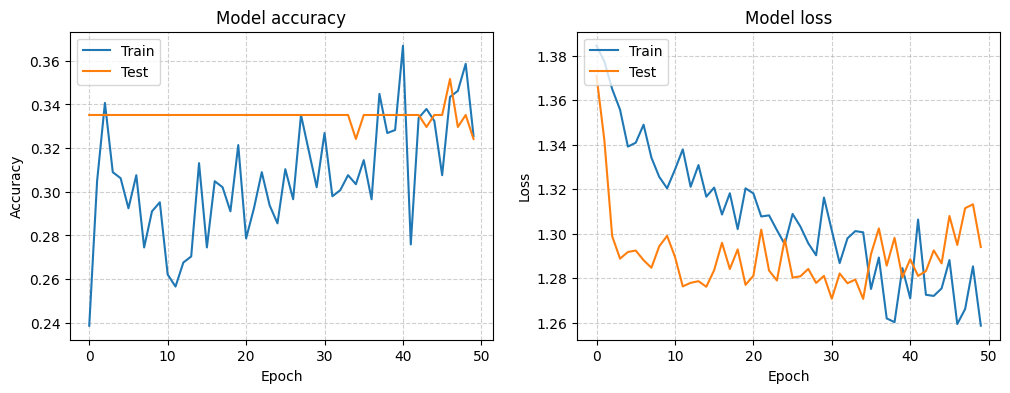

In [ ]:
# Plot training & validation accuracy values
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.grid(linestyle='--', alpha=0.6)
# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.grid(linestyle='--', alpha=0.6)
plt.show()

In [ ]:
# classification report
from sklearn.metrics import classification_report, confusion_matrix

y_pred_probs = model.predict(
    [test_residual_scaled.reshape(-1, 100, 1),
     test_seasonal_scaled.reshape(-1, 100, 1),
     test_trend_scaled.reshape(-1, 100, 1)]
)
y_pred = label_encoder.inverse_transform(np.argmax(y_pred_probs, axis=1))
print(classification_report(y_test, y_pred))

8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 234ms/step
              precision    recall  f1-score   support

        High       0.36      0.93      0.52        75
         Low       0.00      0.00      0.00        28
      Medium       1.00      0.01      0.03        78
 Medium High       0.27      0.20      0.23        46

    accuracy                           0.35       227
   macro avg       0.41      0.29      0.19       227
weighted avg       0.52      0.35      0.23       227



/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

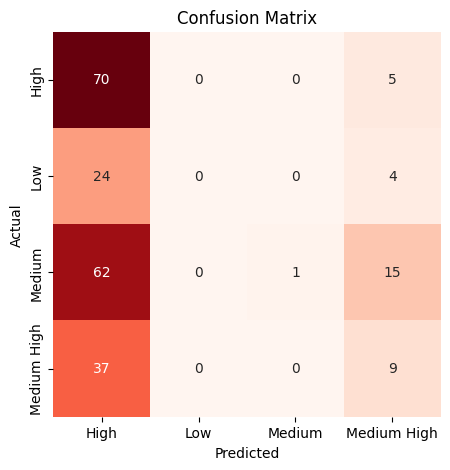

In [ ]:
import seaborn as sns
cm = confusion_matrix(y_test, y_pred, labels=label_encoder.classes_)
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_, cmap='Reds', cbar=False)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

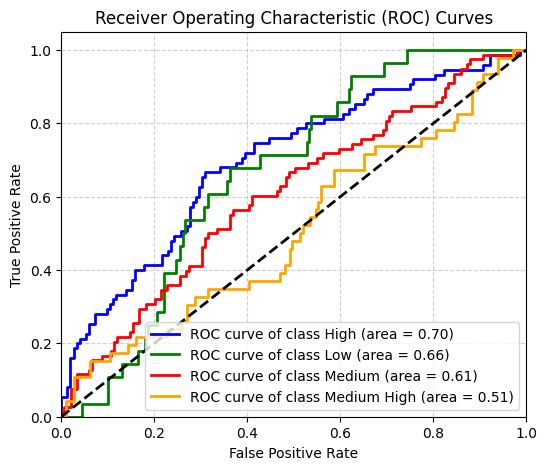

In [ ]:
# Plot ROC curves for each class

from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
y_test_binarized = label_binarize(y_test, classes=label_encoder.classes_)
n_classes = y_test_binarized.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
# Plot all ROC curves
plt.figure(figsize=(6, 5))
colors = ['blue', 'green', 'red', 'orange']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(label_encoder.classes_[i], roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="lower right")
plt.grid(linestyle='--', alpha=0.6)
plt.show()

In [63]:
scaler = StandardScaler()

train_scaled = scaler.fit_transform(X_train[ts_columns])
val_scaled = scaler.transform(X_val[ts_columns])
test_scaled = scaler.transform(X_test[ts_columns])

In [ ]:
from tensorflow.keras.layers import GRU
# RNN on the non split data

def model_initial_data(data_shape, num_classes):
    inputs = Input(shape=data_shape)
    x = GRU(16, return_sequences=True)(inputs)
    x = GRU(32, return_sequences=True)(x)
    x = GRU(16, return_sequences=False)(x)
    x = Dropout(0.2)(x)
    x = Dense(8, activation='relu')(x)
    x = Dropout(0.3)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=Adam(learning_rate=0.0003), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [141]:
model2 = model_initial_data(data_shape=(100, 1), num_classes=y_train_enc.shape[1])
model2.summary()

Model: "functional_33"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_31 (InputLayer)     │ (None, 100, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_12 (GRU)                    │ (None, 100, 16)        │           912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_86 (Dropout)            │ (None, 100, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_13 (GRU)                    │ (None, 100, 32)        │         4,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_87 (Dropout)            │ (None, 100, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_14 (GRU)                    │ (None, 16)             │         2,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_74 (Dense)                │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_88 (Dropout)            │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_75 (Dense)                │ (None, 4)              │            36 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,284 (32.36 KB)

 Trainable params: 8,284 (32.36 KB)

 Non-trainable params: 0 (0.00 B)

In [142]:
weights_2 = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_train),
    y=y_train
)

weights_2 = dict(enumerate(weights_2))

# Train the model
history_2 = model2.fit(
    train_scaled.reshape(-1, 100, 1),
    y_train_enc,
    validation_data=(
        val_scaled.reshape(-1, 100, 1),
        y_val_enc
    ),
    epochs=50,
    batch_size=32,
    verbose=1,
    class_weight=weights_2
)

Epoch 1/50


23/23 ━━━━━━━━━━━━━━━━━━━━ 11s 95ms/step - accuracy: 0.2661 - loss: 1.4354 - val_accuracy: 0.2308 - val_loss: 1.3513
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - accuracy: 0.2791 - loss: 1.3608 - val_accuracy: 0.3407 - val_loss: 1.3322
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - accuracy: 0.3289 - loss: 1.3249 - val_accuracy: 0.3352 - val_loss: 1.3206
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - accuracy: 0.2608 - loss: 1.3540 - val_accuracy: 0.3571 - val_loss: 1.3194
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - accuracy: 0.2980 - loss: 1.2917 - val_accuracy: 0.3462 - val_loss: 1.3148
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 97ms/step - accuracy: 0.3015 - loss: 1.3187 - val_accuracy: 0.3462 - val_loss: 1.3133
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step - accuracy: 0.2889 - loss: 1.3033 - val_accuracy: 0.3407 - val_loss: 1.2995
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - accuracy: 0.3246 - loss: 1.3002 - val_accuracy: 0.3407 - val_loss: 1

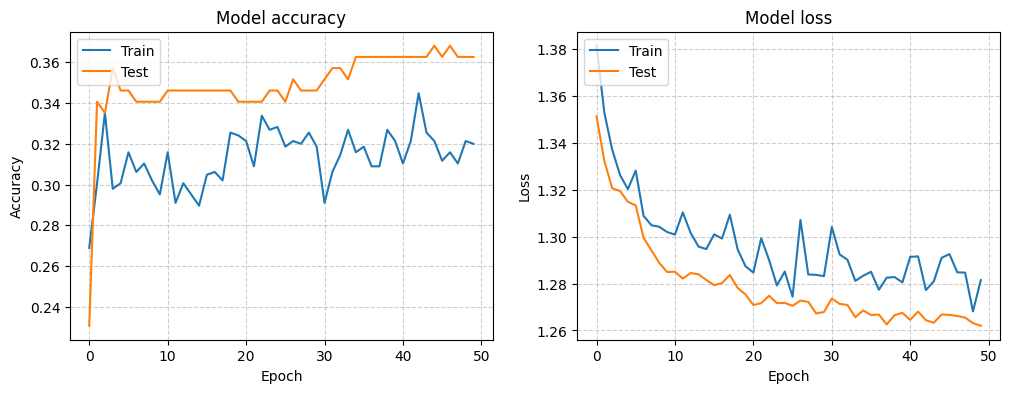

In [143]:
# Plot training & validation accuracy values
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_2.history['accuracy'])
plt.plot(history_2.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.grid(linestyle='--', alpha=0.6)
# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history_2.history['loss'])
plt.plot(history_2.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.grid(linestyle='--', alpha=0.6)
plt.show()

In [144]:
# evaluate the model
test_loss_2, test_accuracy_2 = model2.evaluate(
    test_scaled.reshape(-1, 100, 1),
    y_test_enc,
    verbose=0
)

In [145]:
# classification report
from sklearn.metrics import classification_report, confusion_matrix
print(f'Test Accuracy: {test_accuracy_2:.4f}')
y_pred_probs = model2.predict(
    test_scaled.reshape(-1, 100, 1)
)
y_pred = label_encoder.inverse_transform(np.argmax(y_pred_probs, axis=1))
print(classification_report(y_test, y_pred))

Test Accuracy: 0.3436
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step
              precision    recall  f1-score   support

        High       0.51      0.61      0.55        75
         Low       0.19      0.79      0.31        28
      Medium       0.48      0.13      0.20        78
 Medium High       0.00      0.00      0.00        46

    accuracy                           0.34       227
   macro avg       0.29      0.38      0.27       227
weighted avg       0.35      0.34      0.29       227



/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  